# 10x.x. How to make a color image

<div>
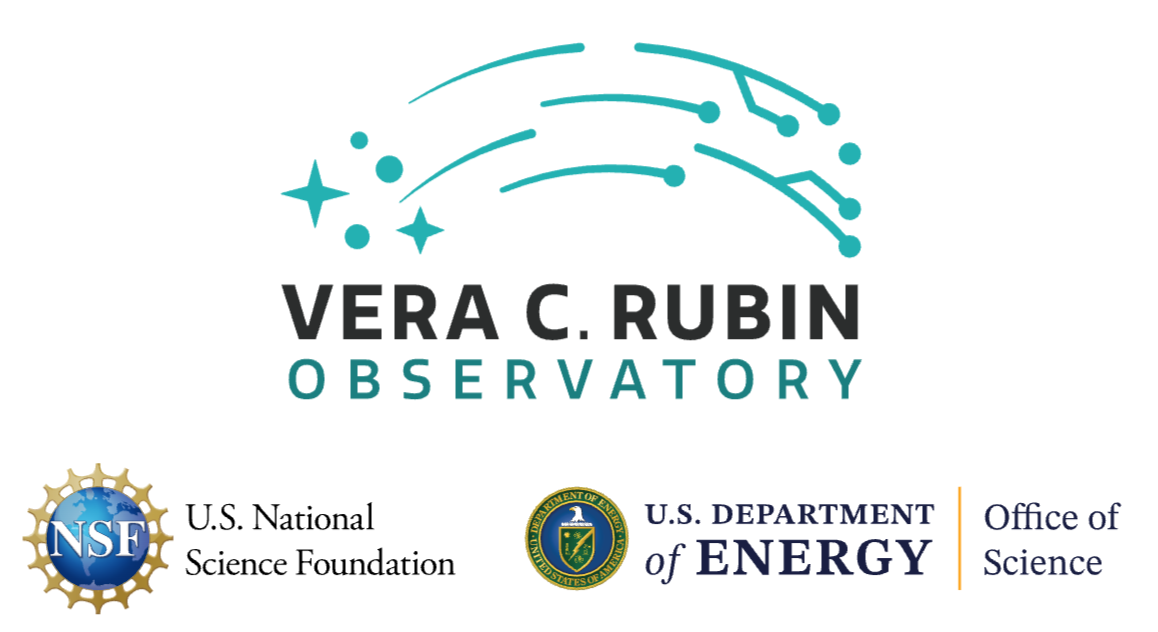
</div>
For the Rubin Science Platform at data.lsst.cloud. <br>
Data Release: <a href="https://dp1.lsst.io">Data Preview 1</a> <br>
Container Size: large <br>
LSST Science Pipelines version: r29.2.0 <br>
Last verified to run: 2025-09-08 <br>
Repository: <a href="https://github.com/lsst/tutorial-notebooks">github.com/lsst/tutorial-notebooks</a> <br>

**Learning objective:** How to make a color image.

**LSST data products:** `deep_coadd`

**Packages:** **Packages:** `lsst.daf.butler`, `lsst.geom`, `lsst.afw.geom`, `lsst.sphgeom`, `lsst.afw.image`, `lsst.pipe.tasks.prettyPictureMaker`, `lsst.ip.diffim`, `lsst.pipe.tasks.makeDiscreteSkyMap`, `matplotlib.pyplot`, `numpy`, `astropy.wcs`

**Credit:** Originally developed by Andrés A. Plazas Malagón, Nate Lust, Clare Higgs, and the Rubin Community Science team.

Section 2 is based on a script by Nate Lust. 

Section 3 is based on a script by Nate Lust and a notebook by Phil Marshall, Phil Holloway, Ralf Kaehler, Ferro Shao, including code from Robert Lupton. 

Section 4 is based on a script by Nate Lust and a notebook by Céline Combet. 

Please consider acknowledging them if this notebook is used for the preparation of journal articles, software releases, or other notebooks.

**Related tutorials:** See the 100-level series on image display.

**Get Support:**
Everyone is encouraged to ask questions or raise issues in the 
<a href="https://community.lsst.org/c/support">Support Category</a> 
of the Rubin Community Forum.
Rubin staff will respond to all questions posted there.

## 1. Introduction

This tutorial demonstrates how to use the [`lsst.pipe.tasks.prettyPictureMaker`](https://github.com/lsst/pipe_tasks/tree/main/python/lsst/pipe/tasks/prettyPictureMaker) code from the LSST Science Pipelines to produce high-quality RGB composite images from multi-band data. 

Section 2 builds and explains the PrettyPictureTask configuration object that controls image stretching, tone mapping, color balance, and other visual aspects. In Section 3, a cutout of an *Euclid* Quick Release 1 strong lens candidate in the Euclid Deep Field South (DP1 field) is made and rendered as a color composite. Finally, in Section 4, Galaxy cluster example, a color composite of the galaxy cluster Abell 360 is displayed.

### 1.1. Import packages

Import the `Butler` module from `lsst.daf.butler` to access data. Use tools from `lsst.geom`, `lsst.afw.geom`, and `lsst.sphgeom` for handling geometry and sky coordinates. Import the `Image` and `Exposure` classes from `lsst.afw.image` for image manipulation. The `PrettyPictureTask` and `ChannelRGBConfig` classes from `lsst.pipe.tasks.prettyPictureMaker` are used for creating color composites, while `GetTemplateTask` from `lsst.ip.diffim` and `MakeDiscreteSkyMapTask` from `lsst.pipe.tasks.makeDiscreteSkyMap` support working with image templates and sky maps. Finally, import `matplotlib.pyplot` and `numpy` for plotting and numerical operations, and the `WCS` class from `astropy.wcs` for handling world coordinate systems.

In [86]:
from lsst.daf.butler import Butler

import lsst.geom as geom
from lsst.afw.geom import makeSkyWcs
from lsst.geom import Box2I, Point2I, Extent2I, SpherePoint, degrees
from lsst.sphgeom import Box as SphBox

from lsst.afw.image import Image, Exposure
from lsst.pipe.tasks.prettyPictureMaker import PrettyPictureTask
from lsst.pipe.tasks.prettyPictureMaker._task import ChannelRGBConfig
from lsst.ip.diffim import GetTemplateTask
from lsst.pipe.tasks.makeDiscreteSkyMap import MakeDiscreteSkyMapTask

import matplotlib.pyplot as plt
import numpy as np
from astropy.wcs import WCS

### 1.2. Define parameters and functions

**Function**: `display_image_array` 

Displays an RGB image from an array.

In [87]:
def display_image_array(image_array, ax=None, figsize=(8, 8), name=None):
    """Display an RGB image from array.

    Parameters
    ----------
    image_array : np.array
        numpy array HxWx3 that corresponds to an RGB image
    ax : matplotlib.axes.Axes, optional
        Axis to draw on; if None, a new Figure and Axes are created.
    figsize : tuple, optional
        Size of the created `matplotlib.Figure` (ignored if `ax` is provided).
    name : str, optional
        Label to annotate the image.
    """
    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(1, 1, 1)

    ax.imshow(image_array, interpolation="nearest", origin="lower")
    ax.axis("off")

    if name:
        ax.text(0, 0.95, name, color="white", fontsize=12, ha="left", va="top", transform=ax.transAxes)

    return

**Function:** `coord_list_to_tract_patch`

Create a list of tract, patch pairs for each coordinate in the input list.

In [88]:
def coord_list_to_tract_patch(coord_list, skymap):
    """Create a list of tract, patch pairs for each coordinate in the input list.

    Parameters
    ----------
    coord_list : `list` of `lsst.geom.SpherePoint`
        List of coordinates for which the closest tract, patch region is to be
        found.
    skymap : `lsst.skymap.BaseSkymap`
        The skymap from where the tract, patch pairs are to be determined.

    Results
    -------
    results : `list` of `tuple` of `int`, `int`
        A list the same length as the input which each element is the closest
        tract patch to the corresponding coordinate. A tuple of -1, -1 will
        be returned if a coordinate can't be attributed to a tract, patch.

    Notes
    ----
    The patch number returned is the sequential index used to identify patches
    in the butler.
    """
    results = []
    for coord in coord_list:
        tractInfo = skymap.findTract(coord)
        for patchInfo in tractInfo:
            if patchInfo.getInnerSkyPolygon().contains(coord.getVector()):
                results.append((tractInfo.getId(), patchInfo.getSequentialIndex()))
                break
        else:
            results.append((-1, -1))
    return results

Create an instance of the butler, and assert that it exists.

In [89]:
butler = Butler('dp1', collections='LSSTComCam/DP1')

Define the skymap.

In [90]:
skymap = butler.get("skyMap")

## 2. Configuration

Define the configuration file for `PrettyPictureTask`, and set some parameters.

In [91]:
pretty_pic_config = PrettyPictureTask.ConfigClass()

### 2.1 `localContrastConfig.doLocalContrast`

This parameter toggles local-contrast enhancement in the luminance channel. It defaults to `True`; turn it off for small images or faster processing, and keep it on to boost mid-scale detail in extended objects (e.g., subtle spiral arms). When enabled, contrast is enhanced before color mapping, revealing structures that are close in brightness to their surroundings.

>**Warning**: For DP1, this parameter must be set to `False` to avoid a known bug related to image size mismatches. This bug will not be present in future releases.

In [92]:
pretty_pic_config.localContrastConfig.doLocalContrast = False

### 2.2 `imageRemappingConfig.absMax`

This parameter sets the input data value (for Rubin data, in nJy) that will be treated as "white" in the output image.

If left unset, the brightest pixel in the image might be used as the white point --- but this can be unstable due to rare, very bright pixels in the long tail of the brightness histogram.

In [93]:
pretty_pic_config.imageRemappingConfig.absMax = 11000

### 2.3 `luminanceConfig.stretch`

This parameter controls the strength of the arcsinh stretch applied to the luminance channel.
The arcsinh function compresses the dynamic range of the image while still preserving faint structures, making it well-suited for astronomical images where bright sources and faint details coexist. 

In [94]:
pretty_pic_config.luminanceConfig.stretch = 750

### 2.4 `luminanceConfig.Q`

This is the asinh softening parameter. It controls how rapidly the arcsinh function transitions from a linear regime for faint values to a logarithmic regime for bright values. Smaller values make the transition sharper; larger values make it smoother.

In [95]:
pretty_pic_config.luminanceConfig.Q = 0.7

### 2.5 `luminanceConfig.highlight`, `luminanceConfig.shadow`, `luminanceConfig.midtone`

These parameters control a tone-mapping function applied after the arcsinh stretch, similar to the highlight, shadow, and midtone sliders in many photo-editing applications.
They determine how the luminance values, now scaled to the 0–1 range, are mapped to the final display brightness.

The `highlight` value sets the luminance level that will be mapped to white, while `shadow` sets the level that will be mapped to black.
The `midtone` parameter defines the balance point between white and black, affecting the overall contrast and brightness perception of the image.
Adjusting these values allows fine-tuning of the tonal balance to emphasize particular brightness ranges without altering the color mapping.

In [96]:
pretty_pic_config.luminanceConfig.highlight = 0.905882
pretty_pic_config.luminanceConfig.shadow = 0.12
pretty_pic_config.luminanceConfig.midtone = 0.25

### 2.6 `doPSFDeconcovlve`

This parameter controls whether the image will undergo Point Spread Function (PSF) deconvolution as part of the processing. Due to a typo in the name, the parameter is spelled `doPSFDeconcovlve` in the code. Setting it to `False` disables PSF deconvolution, which can simplify and speed up the processing, especially for tutorial or exploratory work. When enabled, PSF deconvolution can sharpen features in the image by compensating for the blurring effects of the point-spread function, but it also increases computational complexity and may amplify noise in low signal-to-noise regions.

In [97]:
pretty_pic_config.doPSFDeconcovlve = False

### 2.7 `exposureBrackets`

This parameter enables the use of exposure bracketing, an advanced technique for further compressing the dynamic range of an image. Exposure brackets combine differently scaled versions of the same image to retain detail in both the brightest and faintest regions, similar to high dynamic range (HDR) processing in photography. While powerful, this feature can require careful tuning to achieve the desired visual effect. For simplicity and consistency in this tutorial, it is set to `None`, which disables bracketing and uses a single stretch for the entire image.

In [98]:
pretty_pic_config.exposureBrackets = None

### 2.8 `colorConfig.maxChroma` and `colorConfig.saturation`

These parameters control how color intensity changes with brightness. Increasing `maxChroma` and `saturation` produces richer, more vibrant colors compared to the default settings, enhancing visual appeal while preserving the relative color balance of objects in the image.

In [99]:
pretty_pic_config.colorConfig.maxChroma = 80
pretty_pic_config.colorConfig.saturation = 0.6

### 2.9 `channelConfig`

This setting controls how each input band contributes to the red, green, and blue channels of the final RGB image. In the default configuration, the *g* band maps entirely to blue, the *r* band to green, and the *i* band to red, producing a straightforward g–r–i color composite. 

It's possible to assign any floating-point weights, allowing a band to contribute to multiple color channels. This can be used to fine-tune color balance or to include additional bands beyond three by mixing them into the RGB channels (e.g., adding *u* to blue and red to simulate violet, or mixing *z* into red). The mapping is applied uniformly across all brightness levels, so object colors remain consistent regardless of brightness. Keeping each band mapped to a single channel is simplest to interpret, but mixing can provide more flexibility and information.

In [100]:
pretty_pic_config.channelConfig = {}
pretty_pic_config.channelConfig["g"] = ChannelRGBConfig(r=0, g=0, b=1)
pretty_pic_config.channelConfig["r"] = ChannelRGBConfig(r=0, g=1, b=0)
pretty_pic_config.channelConfig["i"] = ChannelRGBConfig(r=1, g=0, b=0)

Define an instance of `PrettyPictureTask` with the configuration file. 

In [101]:
task = PrettyPictureTask(config=pretty_pic_config)

## 3. Euclid lens cutout

Make a cutout of a strong lens candidate from Euclid data in the Euclid Deep Field south DP1 field. 

Define the approximate coordinates of the lens, in degrees.
The coordinates are from ["Euclid Quick Data Release (Q1): The Strong Lensing Discovery Engine"](https://doi.org/10.5281/zenodo.15025832). This is one point, but this demo will be
written as if there were a list of points to consider.

In [102]:
ra_coordinates = [59.626134]
dec_coordinates = [-49.06175]

Define the stamp size.

In [103]:
stamp_size = 32

Define the photometric bands of the input images used to create the composite color image.

In [104]:
bands = ["g", "r", "i"]

Format the bands into a query string.

In [105]:
bands_str = ",".join(f"'{b}'" for b in bands)

Find the tract, patch for each of the RA and DEC coordinate pairs (in this case, just one).

In [106]:
sph_points = [SpherePoint(r, d, degrees) for r, d in zip(ra_coordinates, dec_coordinates)]
skymap_tract_patch = coord_list_to_tract_patch(sph_points, skymap)

Sort into tract–patch keys so that all points can be processed in a single tract–patch combination for efficiency. Because of patch overlap regions, `patch` is a list of one or more patches, and the first one is used.

In [107]:
sorted_tract_patch = {}
for i, (tract, patch) in enumerate(skymap_tract_patch):
    container = sorted_tract_patch.setdefault((tract, patch), list())
    container.append(sph_points[i])

Loop over tract–patch pairs to create RGB images from coadd cutouts.
For each patch, the relevant coadd datasets for the requested bands are fetched through the Butler, with duplicates removed using `set`.
Since all bands in a tract–patch share the same World Coordinate System (WCS), one WCS is used to transform sky coordinates into pixel coordinates.
For every target point, a bounding box is defined to extract a cutout from each band image.
These cutouts are passed to the `PrettyPictureTask`, which produces an RGB image for display.

**Note**: The `PrettyPictureTask` run method natively takes a dictionary mapping of bands as keys to exposures. However, the task also supports arrays via `task.makeInputsFromArrays`, which can be used if the band data have already been preprocessed into numpy arrays.

>**Warning**: Fetching cutouts individually can be inefficient because the Butler re-reads the images for every request; for multiple cutouts, it is usually faster to fetch the full image once and then slice it locally.

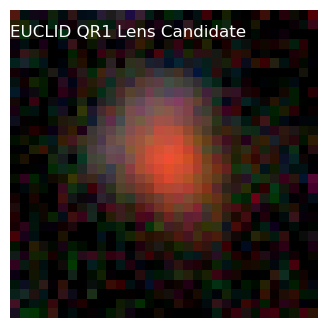

In [108]:
for (tract, patch), points in sorted_tract_patch.items():
    lens_refs = list(
        set(
            butler.query_datasets(
                "deep_coadd",
                patch=patch,
                tract=tract,
                where=f"band in ({bands_str})",
            )
        )
    )

    wcs = skymap[tract].wcs
    coadd_dict = {}
    for ref in lens_refs:
        coadd_dict[ref.dataId["band"]] = butler.get(ref)

    for point in points:
        xy = Point2I(wcs.skyToPixel(point))
        cutoutSize = Extent2I(stamp_size, stamp_size)
        bbox = Box2I(xy - cutoutSize // 2, cutoutSize)

        rgbImage = task.run({k: exp.getCutout(bbox) for k, exp in coadd_dict.items()}).outputRGB
        display_image_array(rgbImage, figsize=(8, 4), name="EUCLID QR1 Lens Candidate")

## 4. Cluster Abell 360

Abell 360 (A360) is a rich galaxy cluster at redshift 0.22 that is included in the DP1 data release.
Create a color composite of the cluster to illustrate the use of `PrettyPictureTask` on a dense field of galaxies.

Define the coordinates of the brightest cluster galaxy (BCG), in degrees.

In [109]:
ra_bcg = 37.865
dec_bcg = 6.98

Define a box size of 0.1 degrees around the BCG, then search for all patches within twice that size (`2 * box_size_deg`).

In [110]:
box_size_deg = 0.1

Redefine the `bands` variable to be a string for the butler query below.

In [111]:
bands = "('g', 'r', 'i')"

In [112]:
box_region = SphBox.fromDegrees(ra_bcg-box_size_deg, dec_bcg-box_size_deg,
                                ra_bcg+box_size_deg, dec_bcg+box_size_deg)

dataset_refs = set(
    butler.query_datasets(
        "deep_coadd",
        where=f"patch.region OVERLAPS(region) and band in {bands}",
        bind={"region": box_region}
    )
)

Prepare the inputs for building a custom skymap.
For each dataset reference, the WCS and bounding box of its patch are stored, so the collection of positions can later define a skymap that includes only the data in use.
At the same time, the dataset references are organized into a nested dictionary: first grouped by band, then within each band grouped by tract.
Each tract key contains all the dataset refs for that tract band combination.

In [113]:
position_container = []
sorted_data = {}
for ds_ref in dataset_refs:
    did = ds_ref.dataId

    patchInfo = skymap[did["tract"]][did["patch"]]
    position_container.append((patchInfo.wcs, patchInfo.outer_bbox))

    band_container = sorted_data.setdefault(did["band"], dict())
    tract_container = band_container.setdefault(did["tract"], list())
    tract_container.append(ds_ref)

The goal is to create an image of an arbitrary sky region that is not aligned with the native LSST sky tessellation.
This is similar to the process in alert production, where past LSST observations are combined to generate static-sky templates for detecting transients in new exposures.
The same template-generation code can be used to transform input data aligned on the LSST tessellation into the required geometry.

To use the template code, a single WCS that encompasses all input data is needed, instead of having a separate tangent-plane WCS for each tract.
A discrete skymap is therefore created for the input data, producing one tract with a single WCS projection.
A bounding box is then defined in these new coordinates, centered on the brightest cluster galaxy (BCG) and spanning the specified width.

With this setup, images are generated per band by combining the inputs that fall within the bounding box.
The `GetTemplateTask` creates coadds for each band, which are then combined into a final RGB mosaic.

First, make a skymap which contains all input data.

In [114]:
new_skymap = MakeDiscreteSkyMapTask().run(position_container).skyMap

Get the new wcs from the single tract discrete skymap.

In [115]:
new_wcs = new_skymap[0].wcs

Create a bounding box in the new WCS coordinates that is centered on the
BCG and has the width defined above.

In [116]:
small_box = Box2I(
    Point2I(new_wcs.skyToPixel(SpherePoint(ra_bcg - box_size_deg,
                                           dec_bcg - box_size_deg, degrees))),
    Point2I(new_wcs.skyToPixel(SpherePoint(ra_bcg + box_size_deg,
                                           dec_bcg + box_size_deg, degrees))),
)

Loop over bands to create images that are combinations of the inputs contained
within the defined box.
Note that the `run` method modifies the bounding box in place, so a copy is made.

In [117]:
getTemplateTask = GetTemplateTask()
coadds = {}
for band, mapping in sorted_data.items():
    small_box_copy = Box2I(small_box)
    new_image = getTemplateTask.run(
        coaddExposures={
            tract: [butler.get(ref) for ref in refs] for tract, refs in mapping.items()
        },
        bbox=small_box_copy,
        wcs=new_wcs,
        dataIds={tract: [ref.dataId for ref in refs] for tract, refs in mapping.items()},
        physical_filter=band,
    ).template
    coadds[band] = new_image

Adjust the `shadow` and `luminance` parameters slightly, and redefine the task so the changes take place. 

In [118]:
pretty_pic_config.luminanceConfig.shadow = 0.15
pretty_pic_config.luminanceConfig.midtone = 0.3

In [119]:
task = PrettyPictureTask(config=pretty_pic_config)

Run the task to make the image.

In [120]:
mosaic_image = task.run(coadds).outputRGB

Display the image.

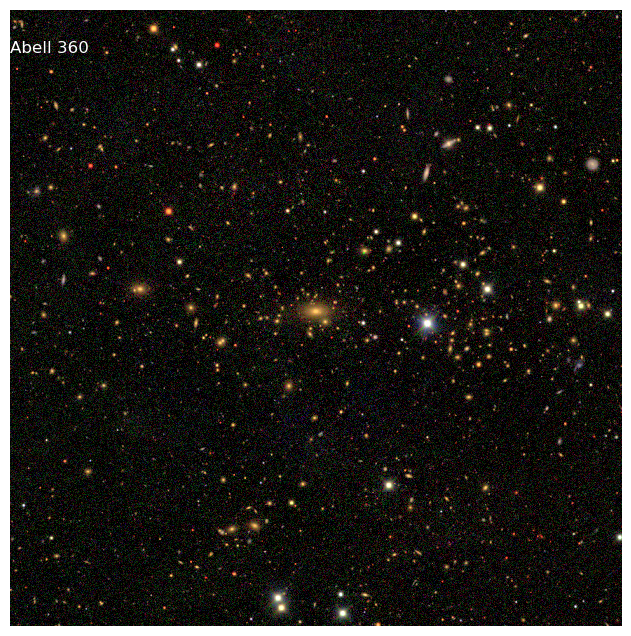

In [121]:
display_image_array(mosaic_image, name="Abell 360")